In [1]:
import numpy as np
from pytisean import tiseanio
from datasets import *
import matplotlib as mpl
from matplotlib import pyplot as plt
from curvature import *
from subprocess import call
from lorenz import get_lorenz
import pandas as pd
import os
print(os.getcwd())

params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)

/home/varad/Dropbox/Personal/code/Curvature/code/d2-experiments


In [2]:
def plot_d2(d2,dims, filename, limits, start_dim=1):
    
    data_per_dim = int(d2.shape[0] / dims)
    plt.figure(figsize=(12,8), dpi=300)
    for dim in range(start_dim,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        
        plt.plot(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1], '.', 
                 #label=r'm=%d, d2=%.2f $\pm$ %.2f' % (dim, p[0], np.sqrt(COV[0][0])))
                 label=r'm=%d, d2=%.2f' % (dim, p[0]))

        #x_coord = np.arange(limits[0],limits[1],0.1)
        #y_coord = x_coord * p[0] + p[1]
        
        #plt.plot(x_coord, y_coord, color='black')
        plt.axvline(x=limits[0], color='black')
        plt.axvline(x=limits[1], color='black')
        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'log ($\epsilon$)', fontsize=20)
    plt.ylabel(r'log (C($\epsilon$))', fontsize=20)    
    plt.legend(prop={'size': 16})
    plt.savefig(filename)
    print("Saving as ", filename)
    plt.show()
    
    
def fit_slopes(d2, dims, limits):
    data_per_dim = int(d2.shape[0] / dims)
    print(limits)
    for dim in range(1,dims+1):
        
        idx = (np.where(np.logical_and(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] >= limits[0],
                            d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0] < limits[1])))
        
        [p, COV] = np.polyfit(d2[(dim-1)* (data_per_dim):(dim * data_per_dim),0][idx], 
                 d2[(dim-1)* data_per_dim:(dim * data_per_dim),1][idx], deg=1, cov=True)
        print(r'embedding dim={}, correlation dimension={}+/-{}'.format(dim, p[0], np.sqrt(COV[0][0])))
        
        

# Lorenz Full

In [3]:
n=100000
step_size=0.01
ds_rate = 1
#n=100000
#timestep=0.05
noise_level = 0.1

[t,data] = get_lorenz(n=n,timestep=step_size)

max_val  = np.zeros(3)
for i in range(3):
    max_val[i] = np.max((data[:,0])) - np.min((data[:,0]))
    
for i in range(3):
    print(max_val[i])
    data[:,i] = data[:,i] + noise_level*max_val[i]*(np.random.random((data.shape[0])) - .5)
    
lorenzTS = data[:,0]
print(lorenzTS.shape)

#max_val = [np.max((data[:,i])) - np.min((data[:,i])) for i in range(3)]
#print(max_val)

(100000, 3)
37.67964806925325
37.67964806925325
37.67964806925325
(90000,)


495
Additional non-data files were created
/home/varad/Dropbox/Personal/code/Curvature/code/d2-experiments
Saving as  d2_figures_paper/lorenz_full_noise_0.1_limits_0.8_1.6.png


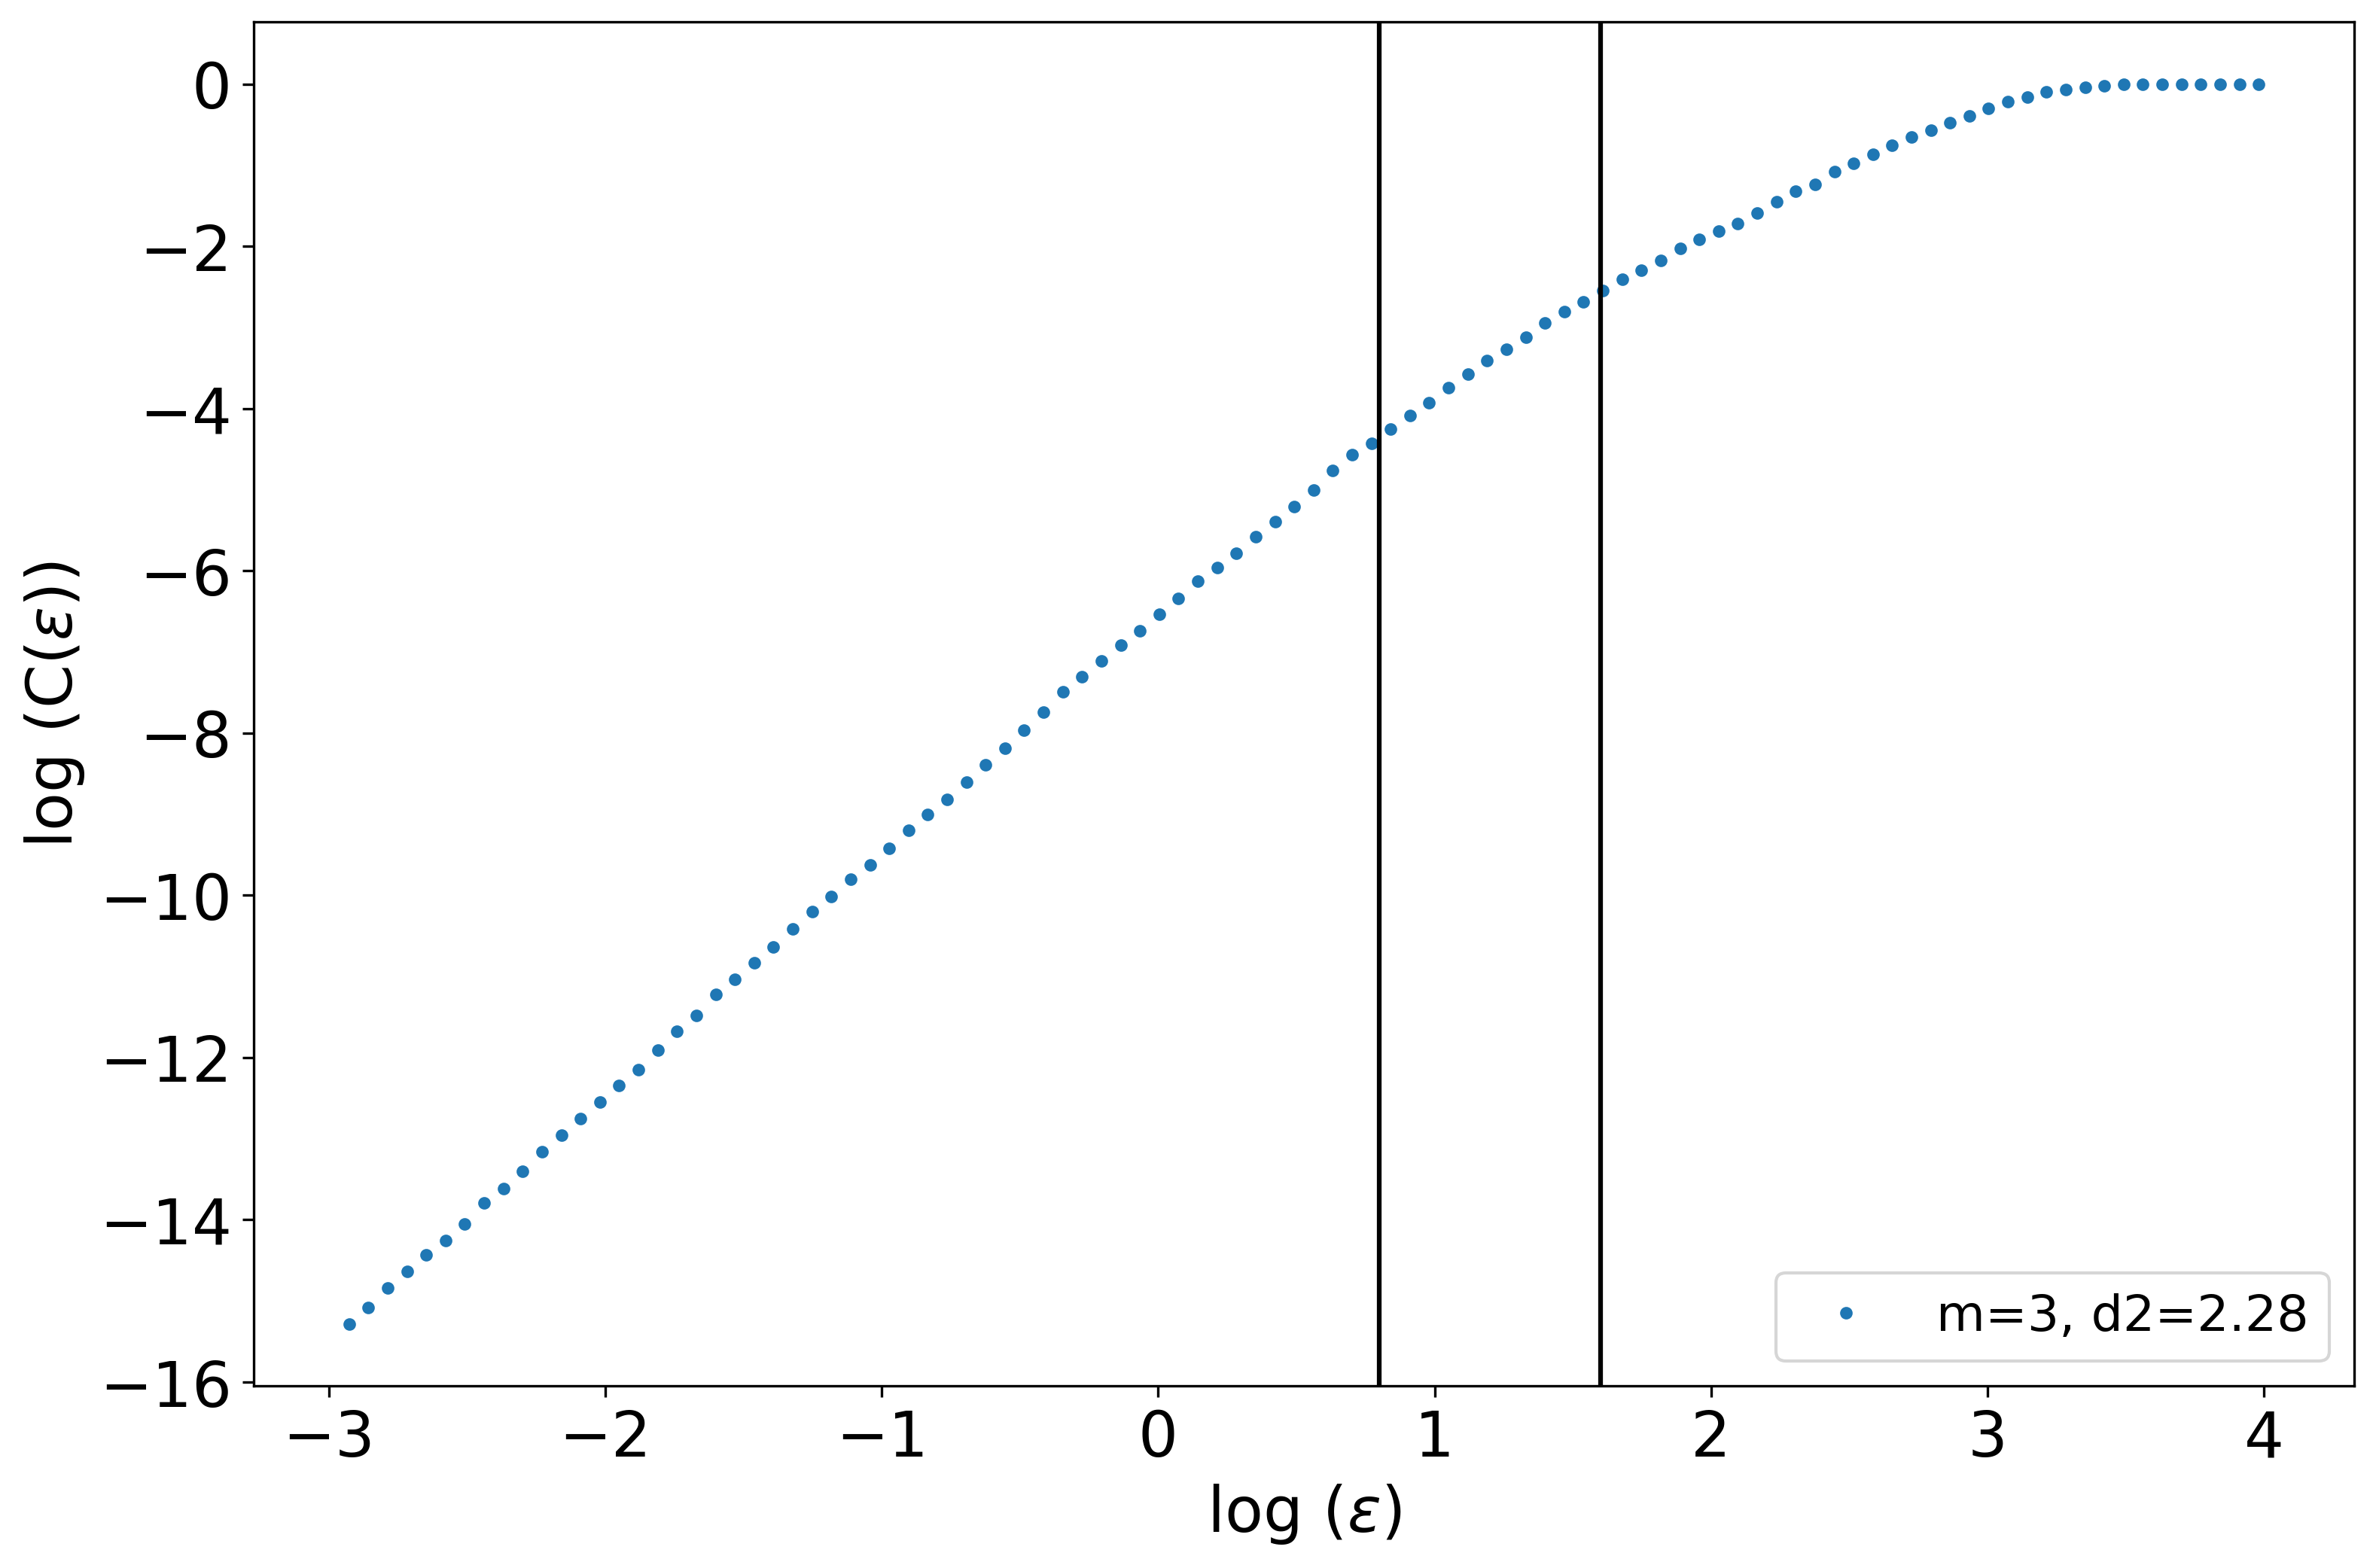

[0.8, 1.6]
embedding dim=1, correlation dimension=0.9446391441796193+/-0.012697226694120245
embedding dim=2, correlation dimension=1.5990553575833744+/-0.028184863412723356
embedding dim=3, correlation dimension=2.275234886447229+/-0.029978601421189206


In [4]:
#limits=[-1.5,1]
mpl.rcParams["legend.loc"] = 'lower right'
limits = [0.8,1.6]
dims = 3
#plt.plot(data[:,0],data[:,1],'.',markersize=.1)
#plt.xlabel('X')
#plt.ylabel('Y')
#plt.savefig('lorenz_projection_noise_{}.png'.format(noise_level))

theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-M','3,1','-c','1,2,3', '-t', theiler_window, data=data, silent=True)

c2 = corr[0]['c2']
#log_c2 = np.concatenate((np.log(c2[:,0]).reshape(-1,1), np.log(c2[:,1]).reshape(-1,1)), axis=1)
log_c2 = np.log(c2)
print(os.getcwd())
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_full_noise_{}_limits_{}_{}.png'.format(noise_level, limits[0], limits[1]), limits, start_dim=3)
fit_slopes(log_c2, dims, limits)

In [5]:
tau_max = 100

'''
menger_mean = []
menger_variance = []
for tau in range(1,1000):
    menger = get_menger_centered_avg_embed(embed, 1, 0)
    menger_mean.append(np.mean(menger))
    menger_variance.append(np.var(menger))
'''
def get_menger_tau(data, tau_max):
    menger = [];
    dim = 2
    tau_avg = 1
    n_neighbors = 0
    menger_params = np.array([data.shape[0], 2, tau_max, tau_avg, n_neighbors])
    np.savetxt('menger_params.txt', menger_params)
    np.savetxt('menger_in.txt', data);
    np.savetxt('menger_params.txt', menger_params, fmt="%d")
    
    call(["./menger", "menger_in.txt", "menger_out.txt", "menger_params.txt"])
    menger_data = np.loadtxt("menger_out.txt");
    return menger_data[:,0], menger_data[:,1]

def moving_average(x, window = 4):
    
    s = pd.Series(x)
    s_ma = s.rolling(window).mean()

    return (np.array(s_ma)[window:])

lorenzTS_ma = moving_average(lorenzTS, window=20)

mutual_ma, err = tiseanio('mutual', '-D', tau_max, data=lorenzTS_ma)
mutual, err = tiseanio('mutual', '-D', tau_max, data=lorenzTS)
#embed, err = tiseanio('delay', '-m', 2, '-d', tau, data=lorenzTS, silent=True)

[menger_mean, menger_var] = get_menger_tau(lorenzTS_ma, tau_max)


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

mutual: Estimates the time delayed mutual information
	of the data set

Using /tmp/pytisean_temp_2020-05-25-14-07-02_cp7csseu/inFile as datafile, reading column 1
Use 89980 lines.
Opened /tmp/pytisean_temp_2020-05-25-14-07-02_cp7csseu/outFile for writing


TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

mutual: Estimates the time delayed mutual information
	of the data set

Using /tmp/pytisean_temp_2020-05-25-14-07-02_8brbgb7i/inFile as datafile, reading column 1
Use 90000 lines.
Opened /tmp/pytisean_temp_2020-05-25-14-07-02_8brbgb7i/outFile for writing



In [20]:
print(mutual[0,1], menger_mean[0])
print(menger_mean[15:50])
print(mutual[15:45, 1])
print(mutual[50:80, 1])

print(np.max(menger_mean[20:40]), np.min(menger_mean[15:40]))
print(np.max(mutual[20:40,1]), np.min(mutual[15:25,1]))
print(np.max(mutual[60:80,1]), np.min(mutual[40:80,1]))
print(np.max(mutual[1:,1]),np.min(mutual[1:,1]))
   
print((np.max(menger_mean[20:40]) - np.min(menger_mean[15:40])) / (np.max(menger_mean) - np.min(menger_mean)))
print((np.max(mutual[20:40,1]) - np.min(mutual[15:25,1])) / (np.max(mutual[1:,1]) - np.min(mutual[1:,1])))
print((np.max(mutual[60:80,1]) - np.min(mutual[40:80,1])) / (np.max(mutual[1:,1]) - np.min(mutual[1:,1])))


2.537563 2.56293
[0.853901 0.830746 0.802901 0.774244 0.76959  0.762627 0.764783 0.774784
 0.791643 0.819338 0.851098 0.899129 0.957032 1.0166   1.07539  1.13597
 1.19501  1.24544  1.27237  1.27497  1.27611  1.25376  1.20767  1.17136
 1.11418  1.07072  1.02057  0.972892 0.917309 0.873985 0.83845  0.798175
 0.770294 0.746076 0.722774]
[0.6150211 0.5985118 0.5856064 0.5760149 0.5695222 0.5662617 0.5659475
 0.5651862 0.5677557 0.5724328 0.5769707 0.5841787 0.591217  0.5965608
 0.6014149 0.6030481 0.6029073 0.5978889 0.5936289 0.5833591 0.5694571
 0.5539893 0.5360086 0.5170993 0.4959279 0.4737265 0.45098   0.4268602
 0.4029    0.3794375]
[0.2462724 0.2265935 0.2089453 0.1920966 0.1781962 0.1664977 0.1560666
 0.1490168 0.1438462 0.1422653 0.1440745 0.1493839 0.1583051 0.1708218
 0.1869898 0.2058846 0.2269799 0.2491894 0.2704711 0.2907159 0.3089171
 0.3224975 0.3312012 0.3367464 0.3394566 0.3386129 0.3331561 0.3263695
 0.3155057 0.3025282]
1.27611 0.762627
0.6030481 0.5651862
0.3394566 0.142

No handles with labels found to put in legend.


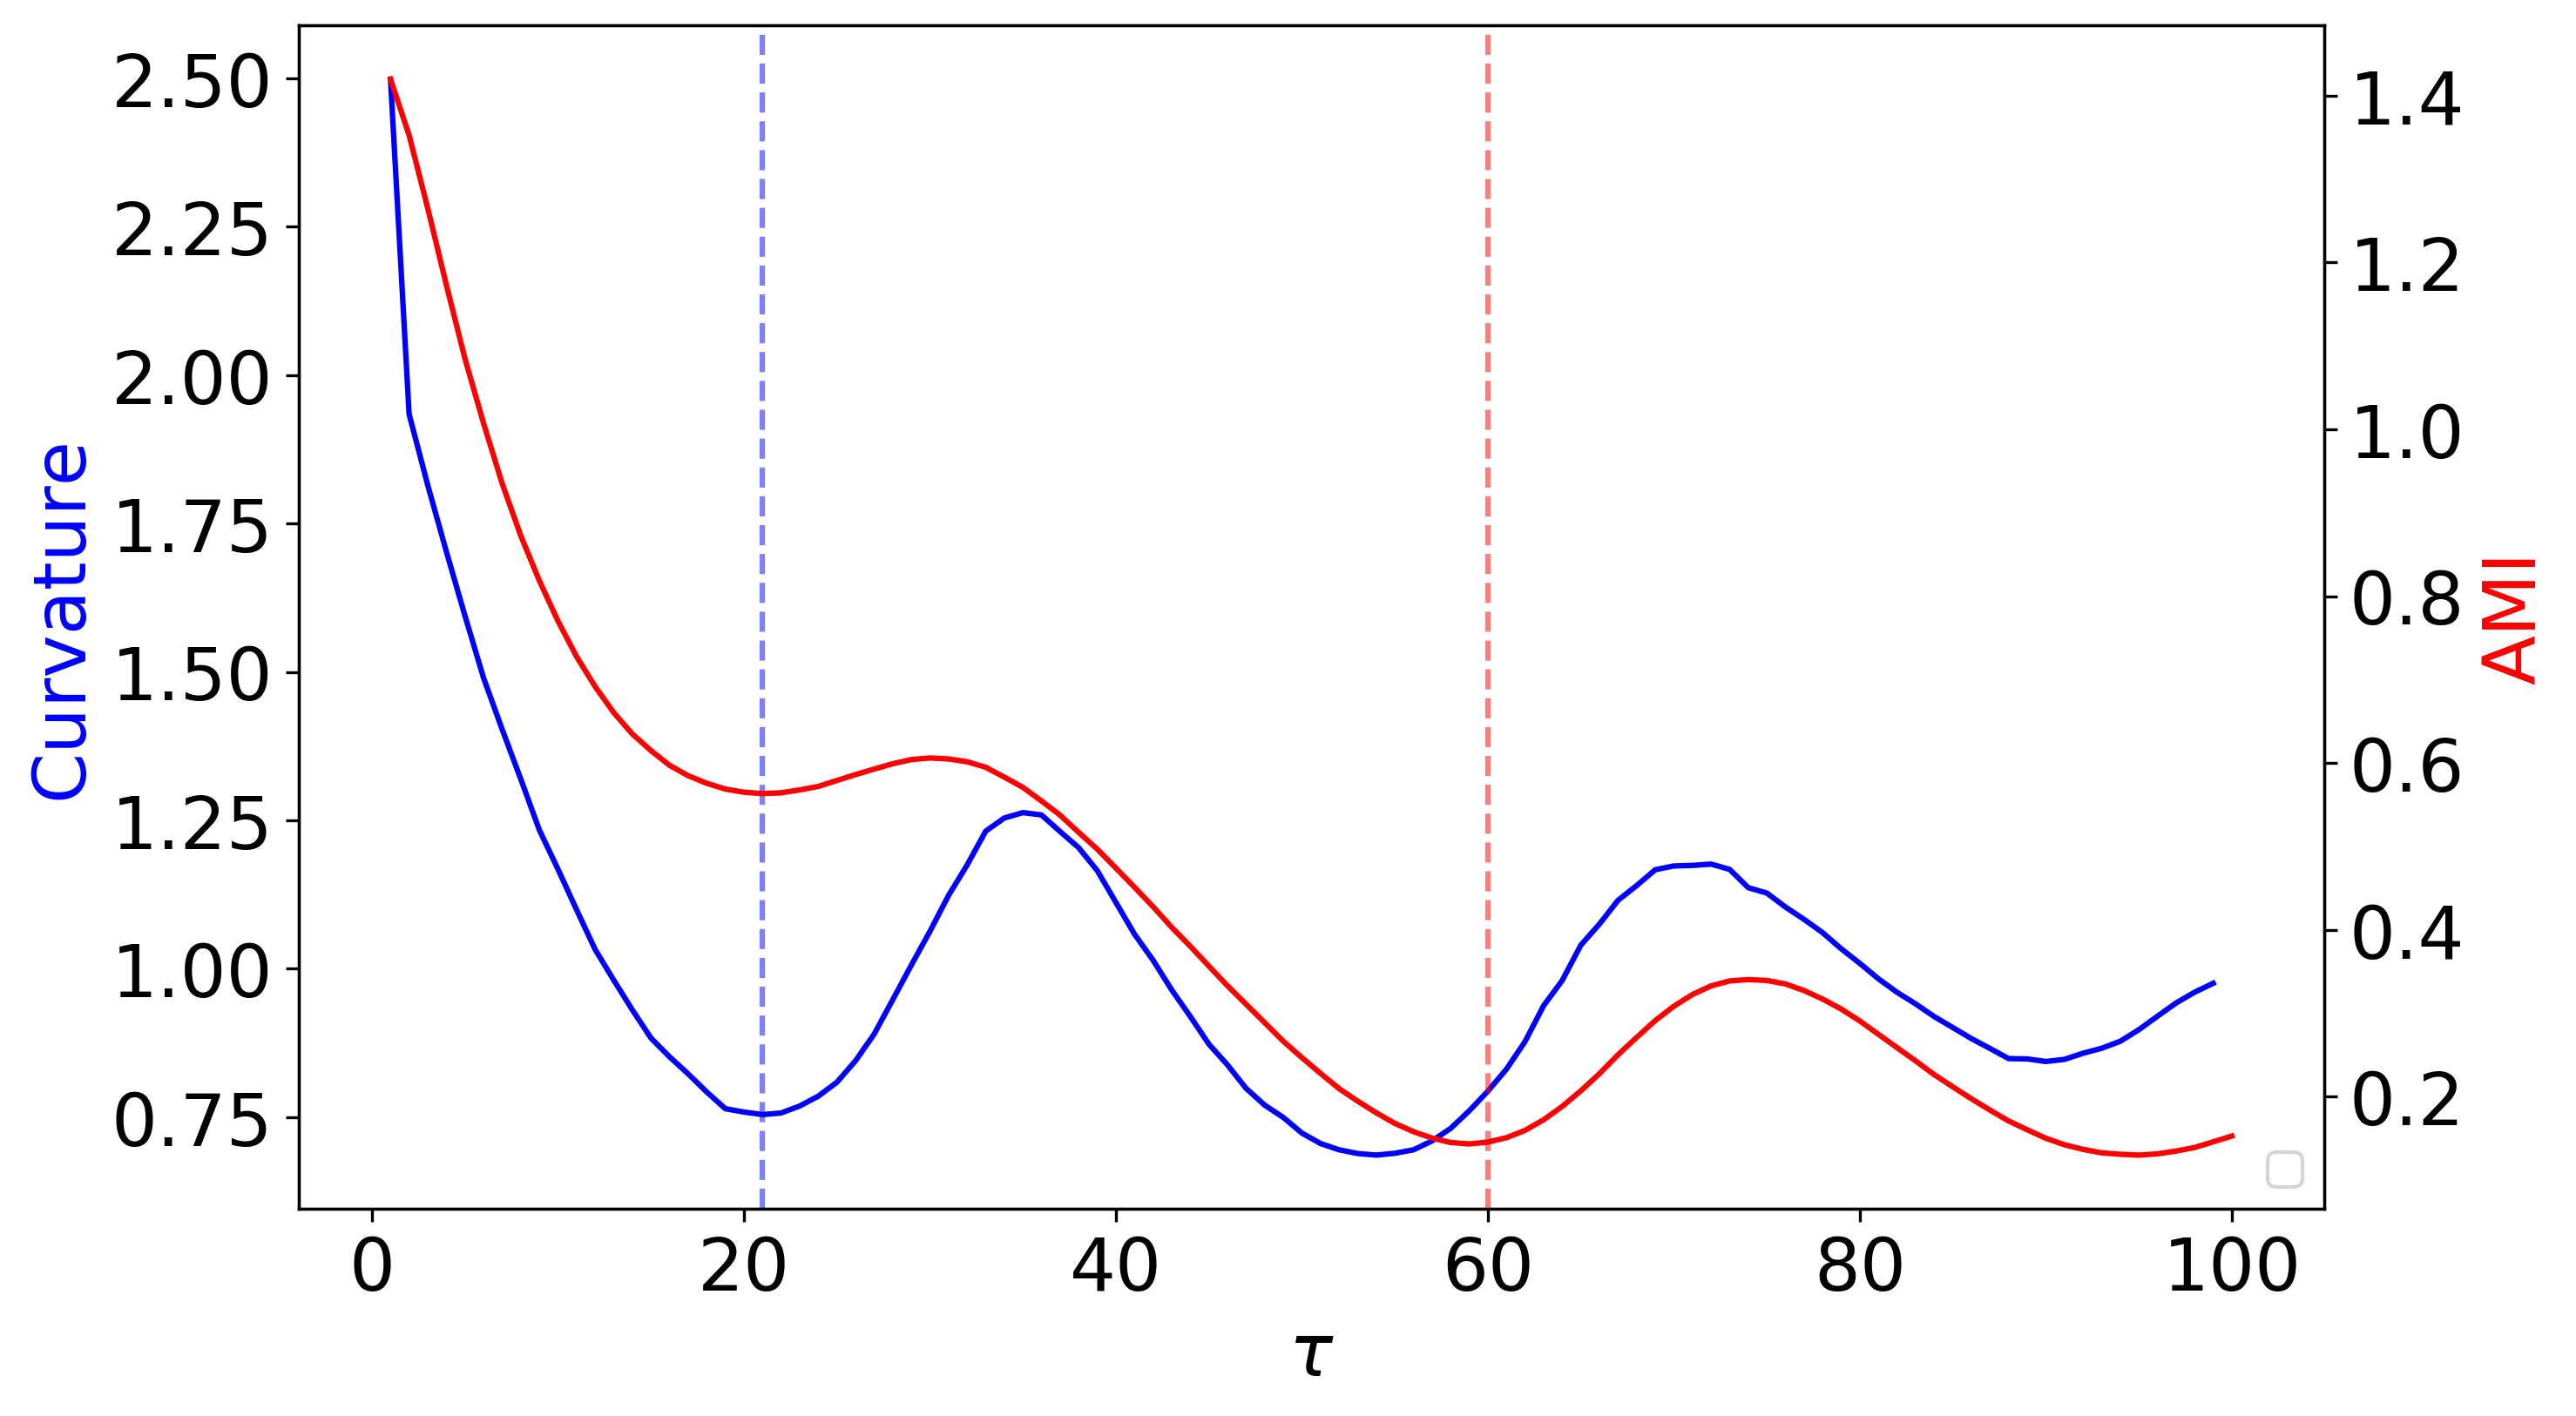

In [7]:
fig, ax1 = plt.subplots(figsize=(10,6), dpi=300)

#plt.plot(menger_var, label = 'curvature variance')
ax1.plot(np.arange(1,tau_max), menger_mean[:], color='b')
ax1.set_xlabel(r'$\tau$', fontsize=20)
ax1.set_ylabel(r'Curvature', color='b', fontsize=20)
ax2 = ax1.twinx()
ax2.plot(mutual[1:,0], mutual[1:,1], color = 'r')
ax2.set_ylabel(r'AMI', color='r', fontsize=20)
ax1.axvline(x = 21, color='b', linestyle='--', alpha=0.5)
ax2.axvline(x = 60, color='r', linestyle='--', alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.legend()
plt.savefig('d2_figures_paper/lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))#
#plt.savefig('lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))

No handles with labels found to put in legend.



TISEAN 3.0.1 (C) R. Hegger, H. Kantz, T. Schreiber (1998-2007)

corr: Estimates the autocorrelations of a data set

Using /tmp/pytisean_temp_2020-04-14-22-05-01_gpvd0zw4/inFile as datafile, reading column 1
Use 90000 lines.
Opened /tmp/pytisean_temp_2020-04-14-22-05-01_gpvd0zw4/outFile for writing



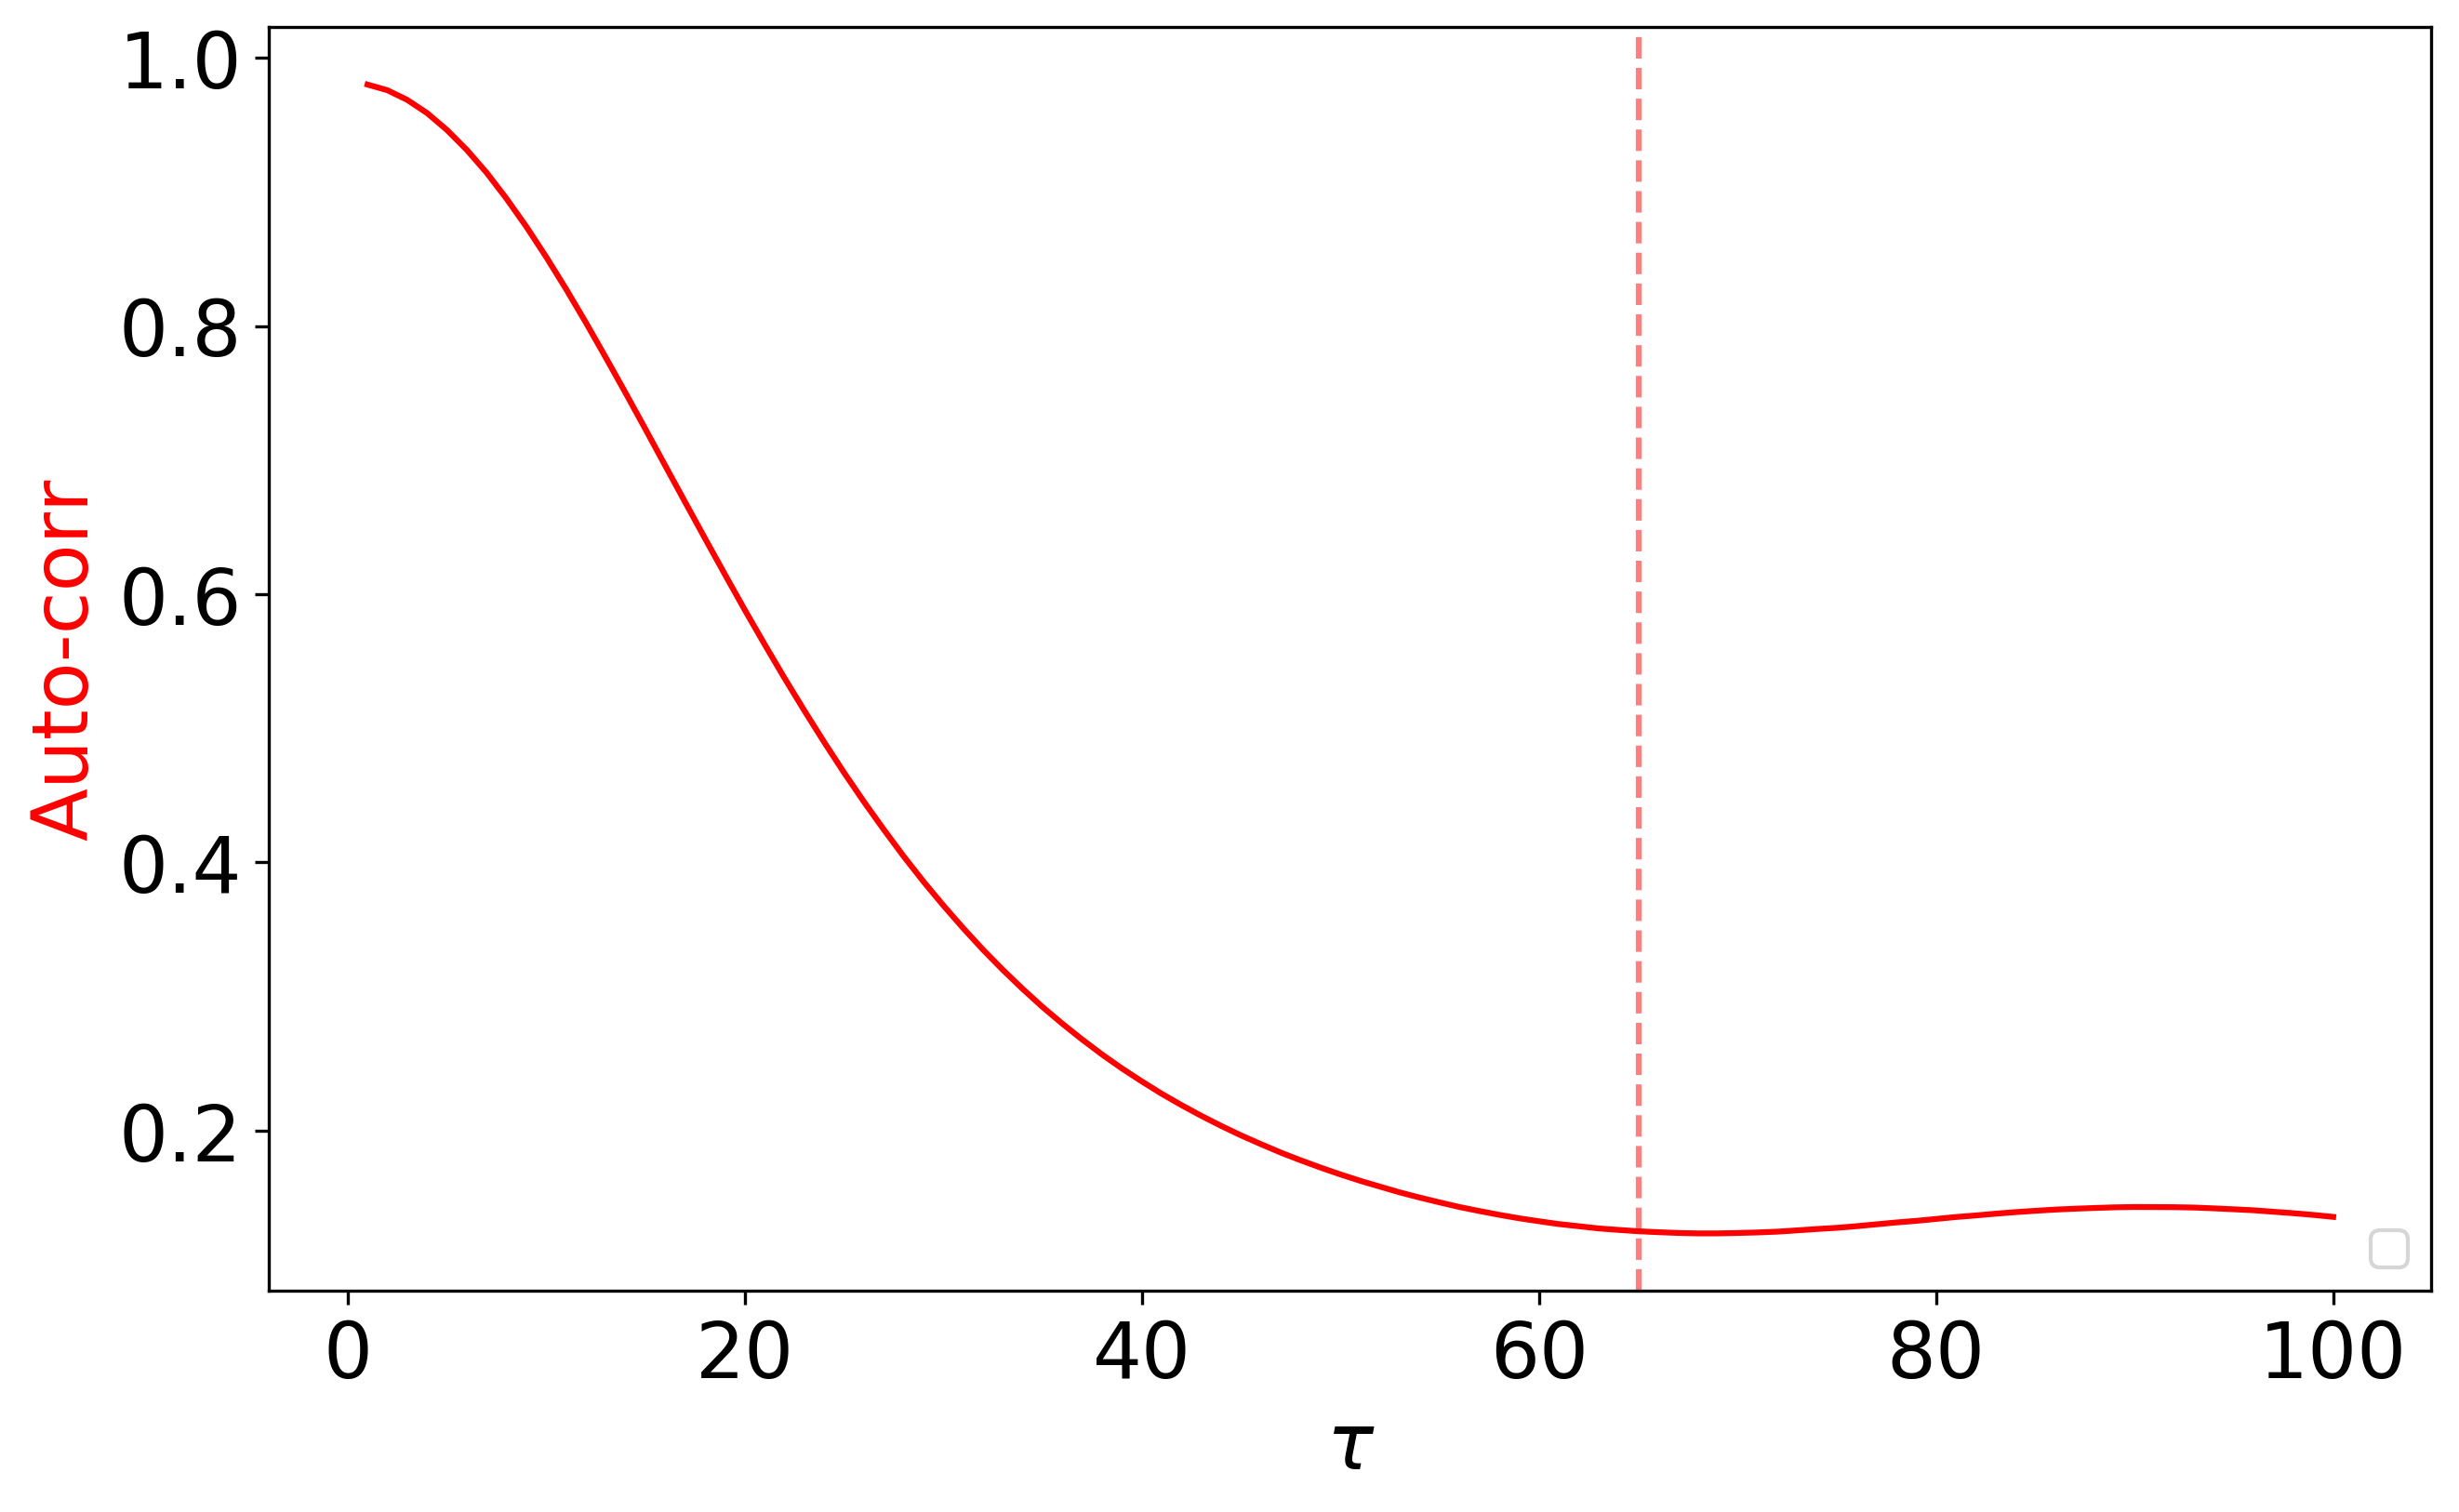

In [13]:
corr_ma, err = tiseanio('corr', '-D', 100, data=lorenzTS)
fig, ax1 = plt.subplots(figsize=(10,6), dpi=300)

#plt.plot(menger_var, label = 'curvature variance')
#ax1.plot(np.arange(1,tau_max), menger_mean[:], color='b')
ax1.set_xlabel(r'$\tau$', fontsize=20)
#ax1.set_ylabel(r'Curvature', color='b', fontsize=20)
#ax2 = ax1.twinx()
ax1.plot(corr_ma[1:,0], corr_ma[1:,1], color = 'r')
ax1.set_ylabel(r'Auto-corr', color='r', fontsize=20)
#ax1.axvline(x = 21, color='b', linestyle='--', alpha=0.5)
ax1.axvline(x = 65, color='r', linestyle='--', alpha=0.5)
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
plt.legend()
plt.savefig('d2_figures_paper/corr/lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))#
#plt.savefig('lorenz_measures_vs_tau_noise_{}.png'.format(noise_level))

# Lorenz tau = 18 (Curvature)

1643
Additional non-data files were created


/home/varad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


Saving as  d2_figures_paper/lorenz_curvature_tau_21_noise_0.1_limits_1.5_2.8.png


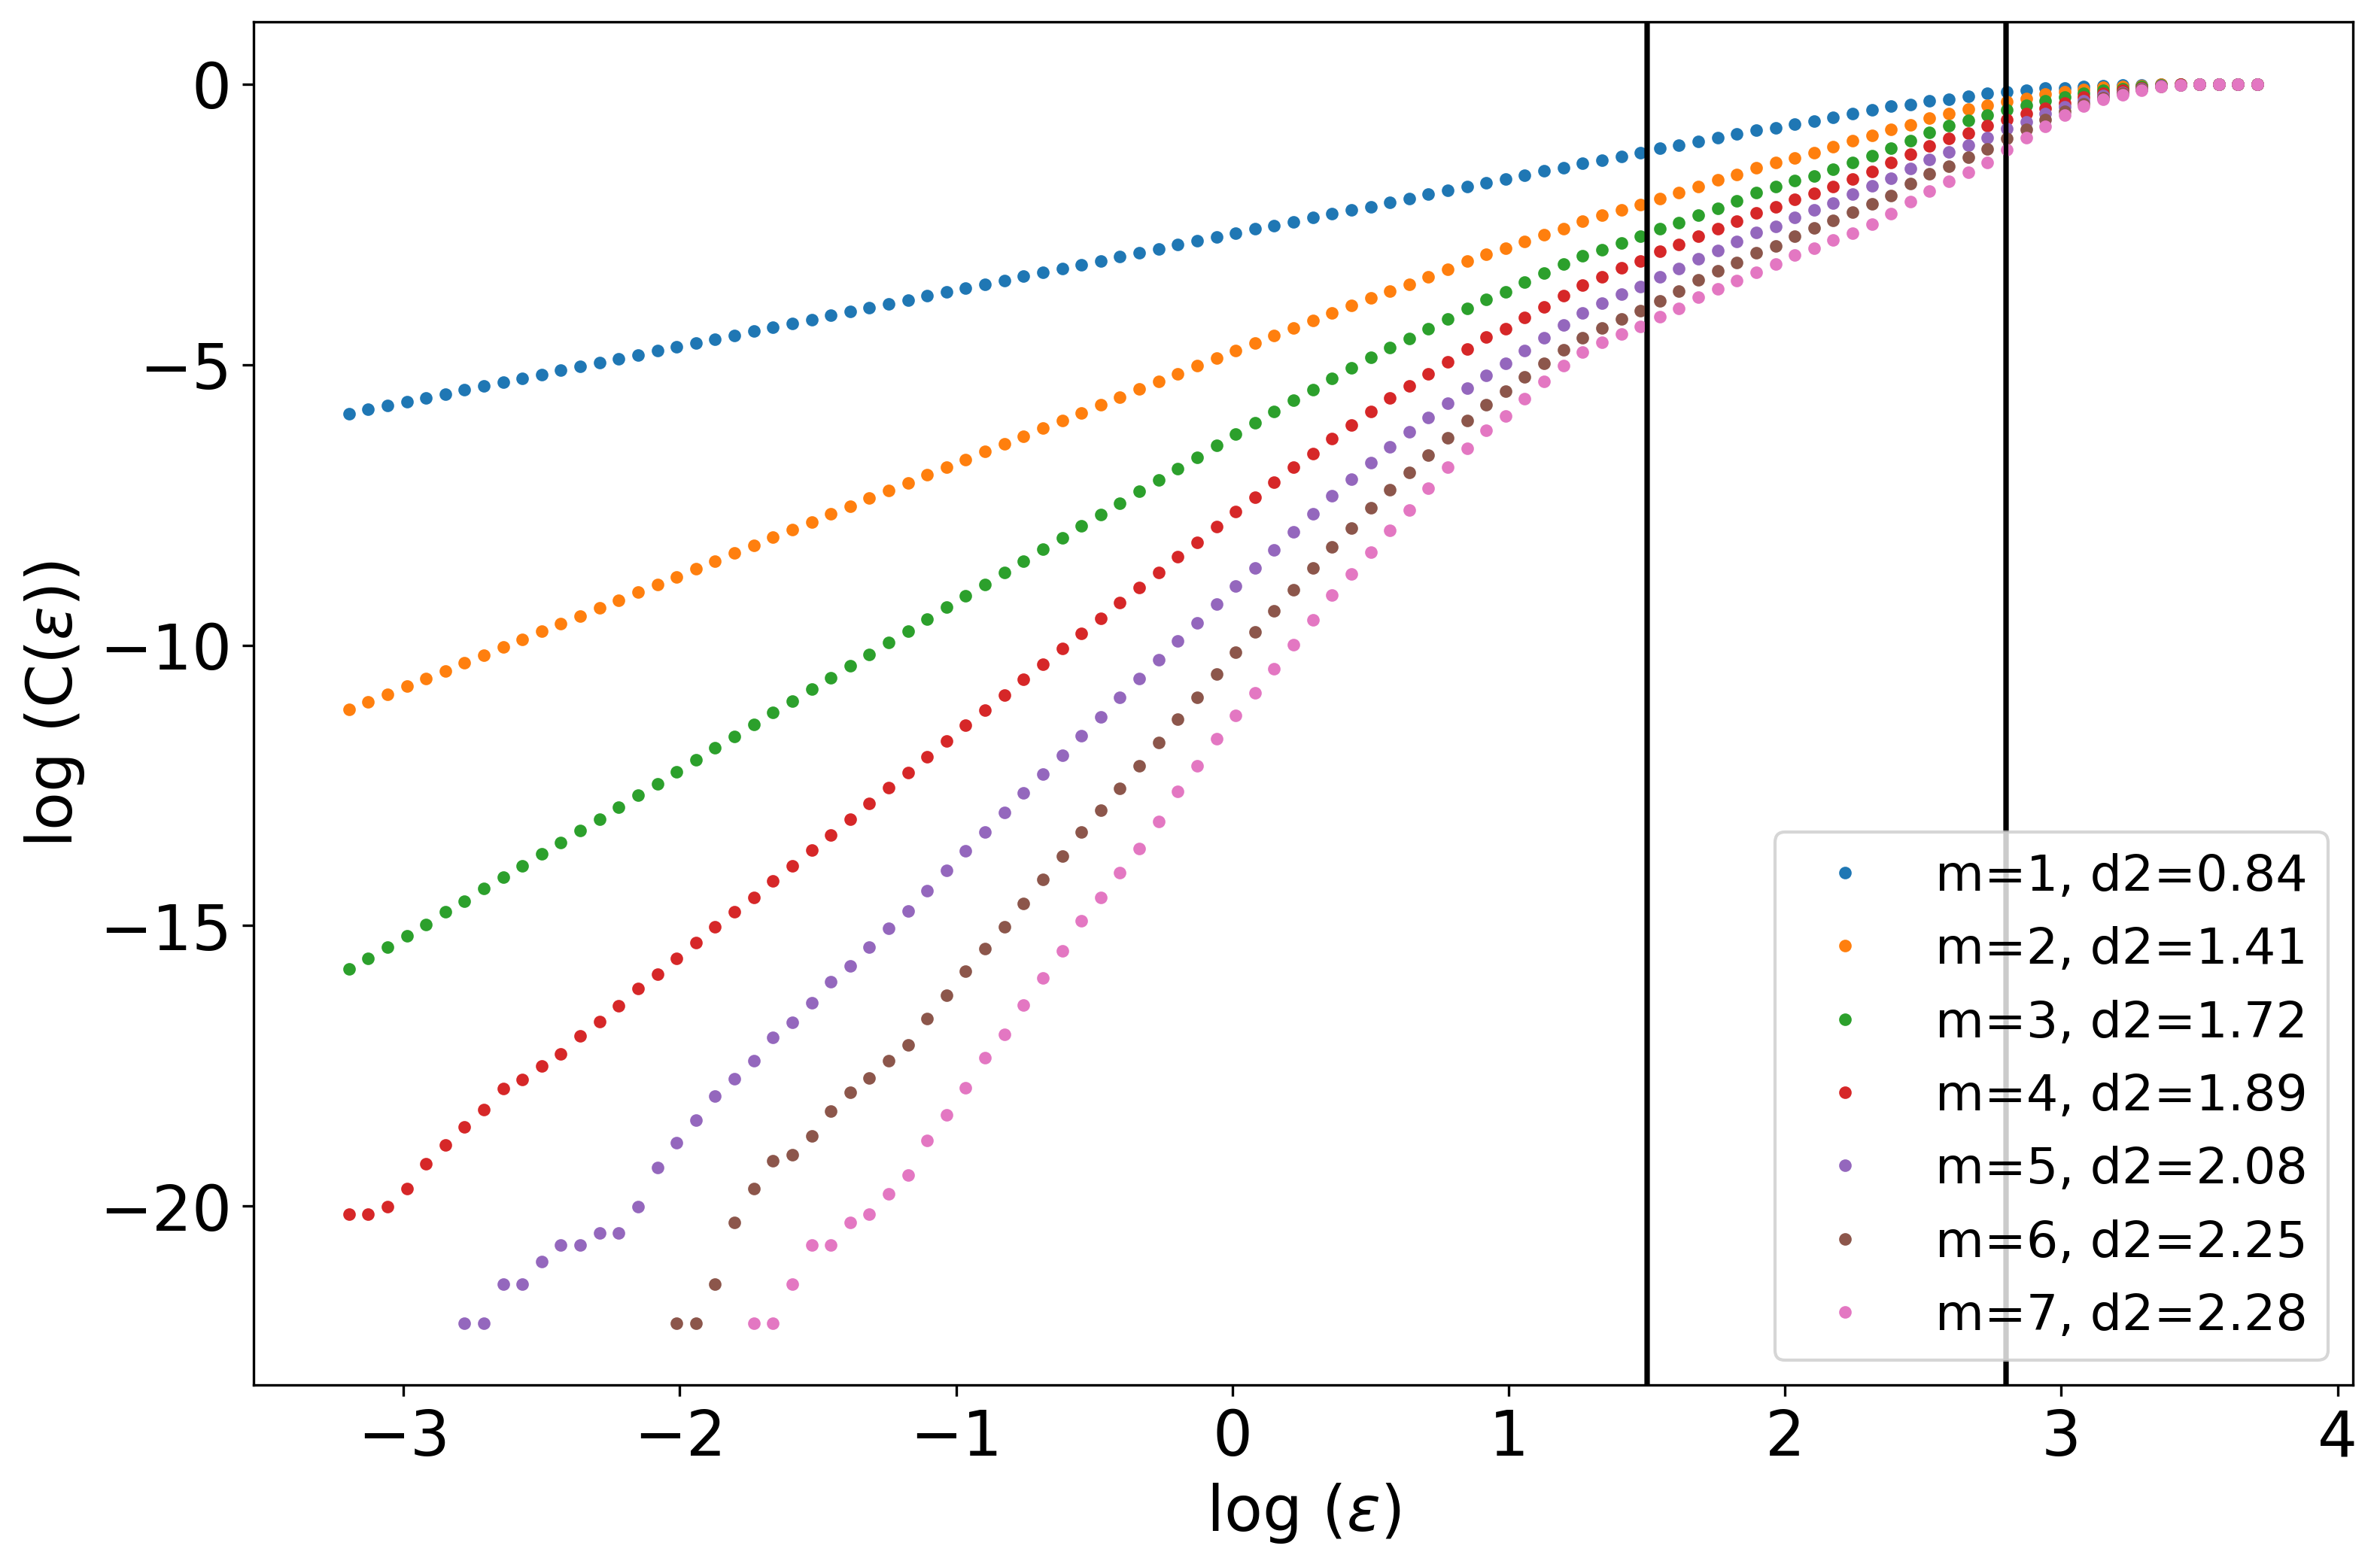

[1.5, 2.8]
embedding dim=1, correlation dimension=0.8379997318009171+/-0.012278279710321428
embedding dim=2, correlation dimension=1.4141618524907085+/-0.012380977773981238
embedding dim=3, correlation dimension=1.7217117277818905+/-0.013045427794130982
embedding dim=4, correlation dimension=1.893924580587362+/-0.013637644391288326
embedding dim=5, correlation dimension=2.0848720496864064+/-0.011590733691712651
embedding dim=6, correlation dimension=2.2496010319653097+/-0.015784548587212576
embedding dim=7, correlation dimension=2.2764081672112497+/-0.028667422933730702


In [24]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]
#tau=18
tau=21
#limits = [-1.8,0.7]
limits = [1.5,2.8]
#series = data_lorenz(0,n=n,tmax=trans)

dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t', theiler_window, data=lorenzTS, silent=True)

c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_curvature_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

# Lorenz tau = 18 (Mutual)

In [ ]:
#[t, data] = get_lorenz(1000,100000)
#series = data[:,0]

#series = data_lorenz(0)
tau = 18
dims = 7
limits=[-2,.5]

theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t',theiler_window, data=lorenzTS, silent=True)

c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

# Lorenz tau = 60 (Mutual)



1217
Additional non-data files were created


/home/varad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Saving as  d2_figures_paper/lorenz_mutual_tau_60_noise_0.1_limits_1.8_2.5.png


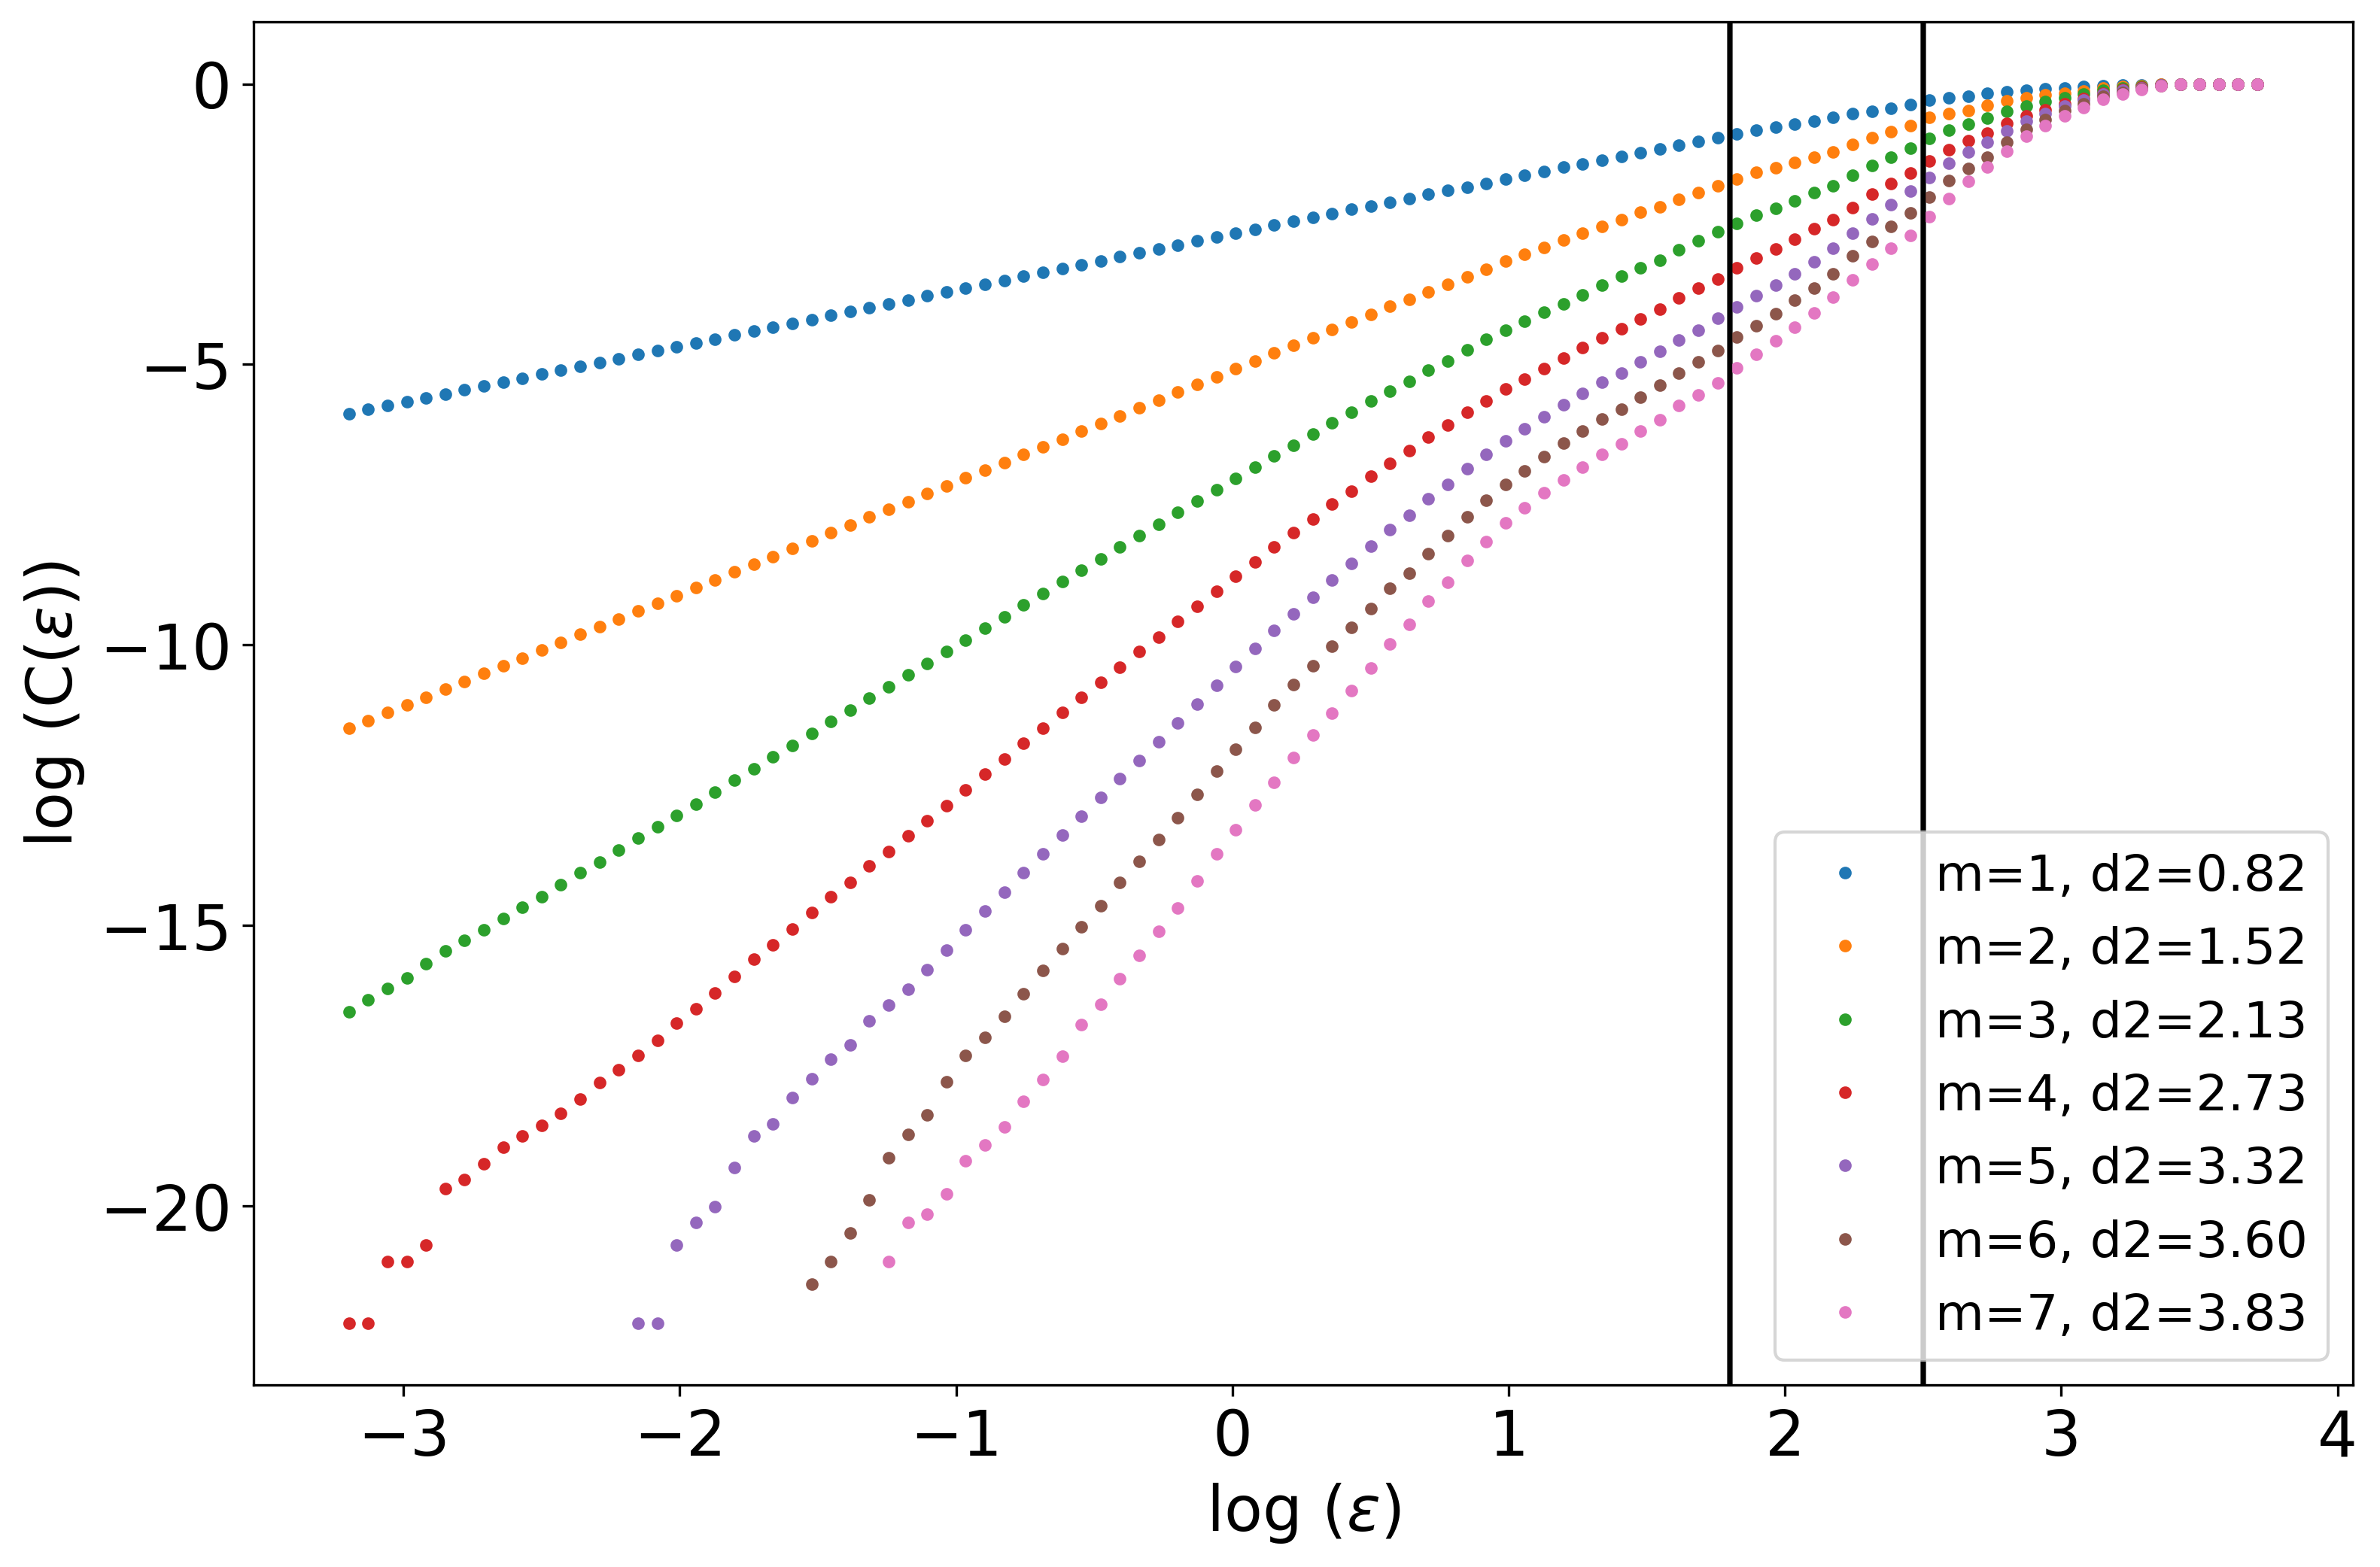

[1.8, 2.5]
embedding dim=1, correlation dimension=0.8202224474840845+/-0.008854351676694553
embedding dim=2, correlation dimension=1.516781988763925+/-0.026221173874131403
embedding dim=3, correlation dimension=2.1315626627339532+/-0.037988070513198725
embedding dim=4, correlation dimension=2.725147903994287+/-0.050488230515050386
embedding dim=5, correlation dimension=3.3209021864907116+/-0.07407467536391256
embedding dim=6, correlation dimension=3.5988770858620773+/-0.06861757351768437
embedding dim=7, correlation dimension=3.8309688154702655+/-0.05371967474125448


In [27]:
tau = 60
dims = 7

limits = [1.8,2.5]
#limits = [-1,1.2]

#plt.figure()
#plt.plot(lorenzTS[:-tau], lorenzTS[tau:], '.', markersize=.1)
#plt.xlabel(r'$X_{t}$', fontsize=12)
#plt.ylabel(r'$X_{t+\tau}$', fontsize=12)
#plt.savefig('lorenz_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t',theiler_window, data=lorenzTS, silent=True)
c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
#plot_d2(log_c2, dims, './lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

1293
Additional non-data files were created


/home/varad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


Saving as  d2_figures_paper/corr/lorenz_mutual_tau_65_noise_0.1_limits_2.0_2.56.png


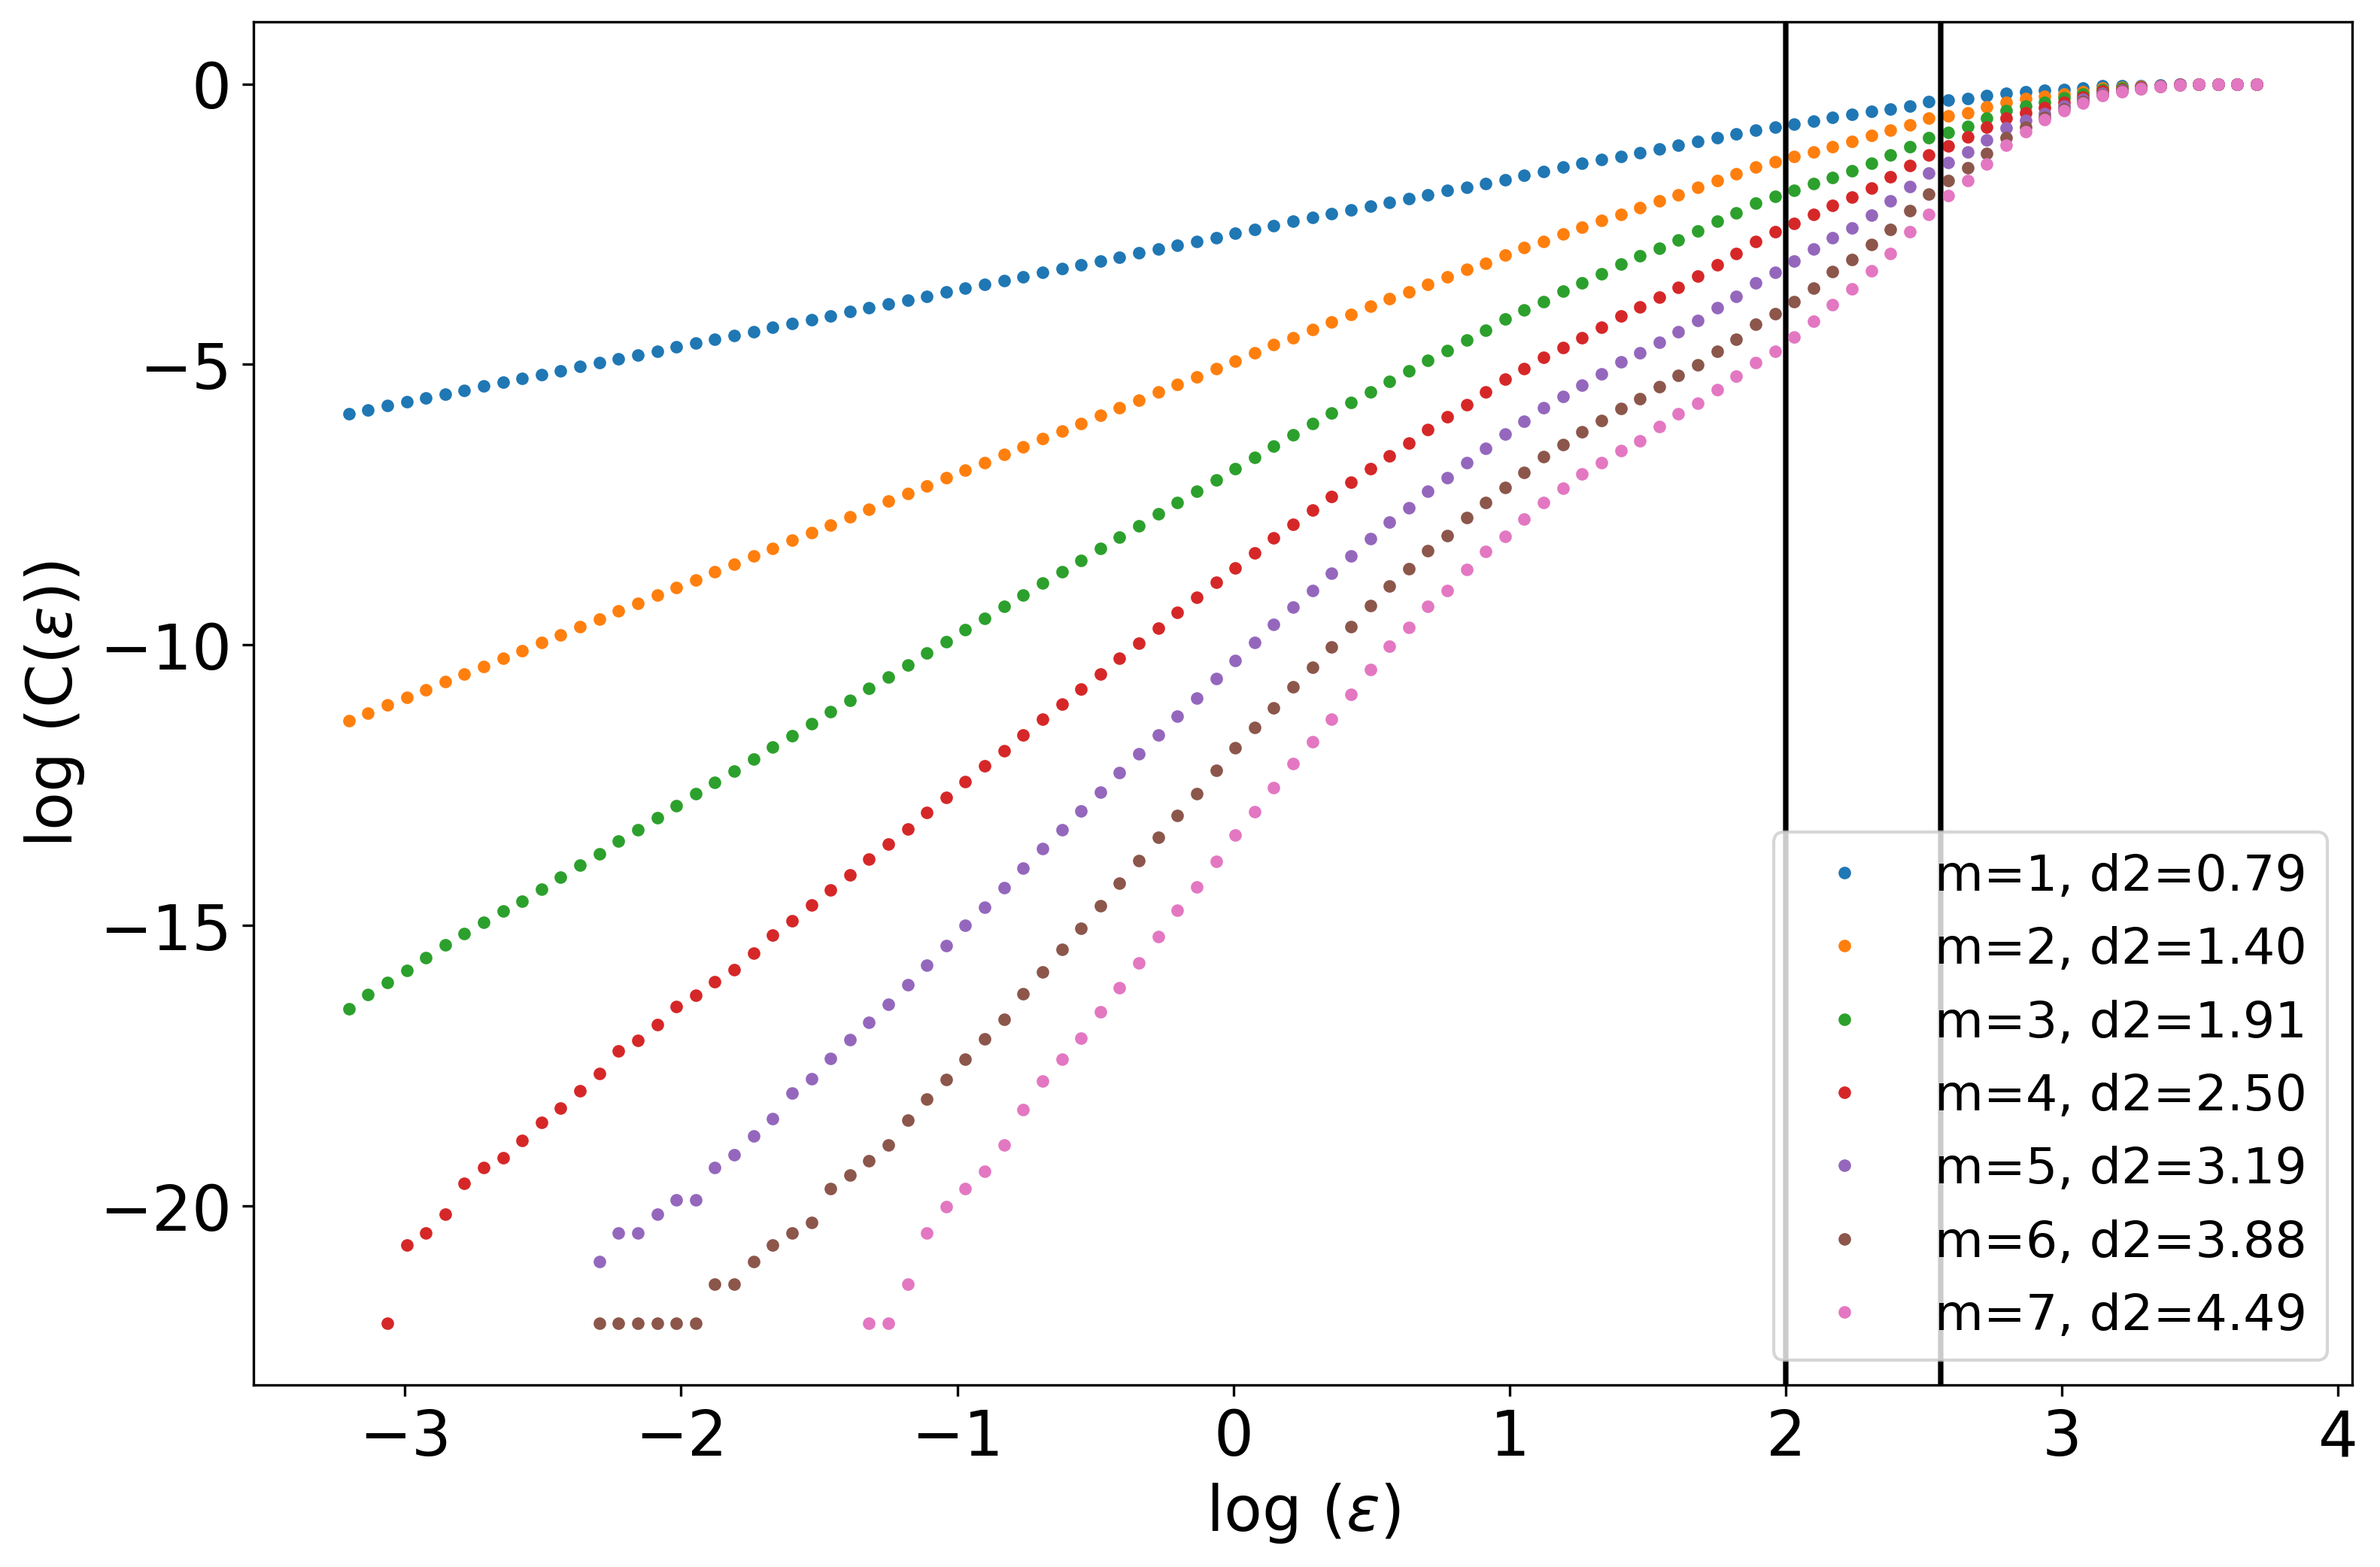

[2.0, 2.56]
embedding dim=1, correlation dimension=0.79221249006543+/-0.01982474458017128
embedding dim=2, correlation dimension=1.4034884814292217+/-0.025243661936649384
embedding dim=3, correlation dimension=1.9130150385760494+/-0.049968425015369855
embedding dim=4, correlation dimension=2.4969291372962137+/-0.0594008806396695
embedding dim=5, correlation dimension=3.1862271142263503+/-0.07570548996161307
embedding dim=6, correlation dimension=3.88410684166181+/-0.08189546269831025
embedding dim=7, correlation dimension=4.486613018866674+/-0.08462562781096304


In [16]:
tau = 65
dims = 7

limits = [2.0,2.6]
#limits = [-1,1.2]

#plt.figure()
#plt.plot(lorenzTS[:-tau], lorenzTS[tau:], '.', markersize=.1)
#plt.xlabel(r'$X_{t}$', fontsize=12)
#plt.ylabel(r'$X_{t+\tau}$', fontsize=12)
#plt.savefig('lorenz_reconstruction_{}_ds_rate_{}.png'.format(tau, ds_rate))

dims = 7
theiler_window = int(2.718**limits[-1]/step_size/ds_rate)
print(theiler_window)
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t',theiler_window, data=lorenzTS, silent=True)
c2 = corr[0]['c2']
log_c2 = np.log(c2)
plot_d2(log_c2, dims, 'd2_figures_paper/corr/lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
#plot_d2(log_c2, dims, './lorenz_mutual_tau_{}_noise_{}_limits_{}_{}.png'.format(tau, noise_level, limits[0], limits[1]), limits)
fit_slopes(log_c2, dims, limits)

In [ ]:
fnn_curvature, err = tiseanio('false_nearest', '-D', '18', '-m', '1', '-M', '1,10', '-t', 100, data=lorenzTS, silent=True)
fnn_ami, err = tiseanio('false_nearest', '-D', '60', '-m', '1', '-M', '1,10', '-t', 100, data=lorenzTS, silent=True)

In [ ]:
plt.plot(fnn_curvature[:,1])
plt.plot(fnn_ami[:,1])

In [ ]:
plt.plot(lorenzTS[:-18], lorenzTS[18:], '.' ,markersize=.1)
plt.plot(lorenzTS[:-60], lorenzTS[60:], '.' ,markersize=.1)

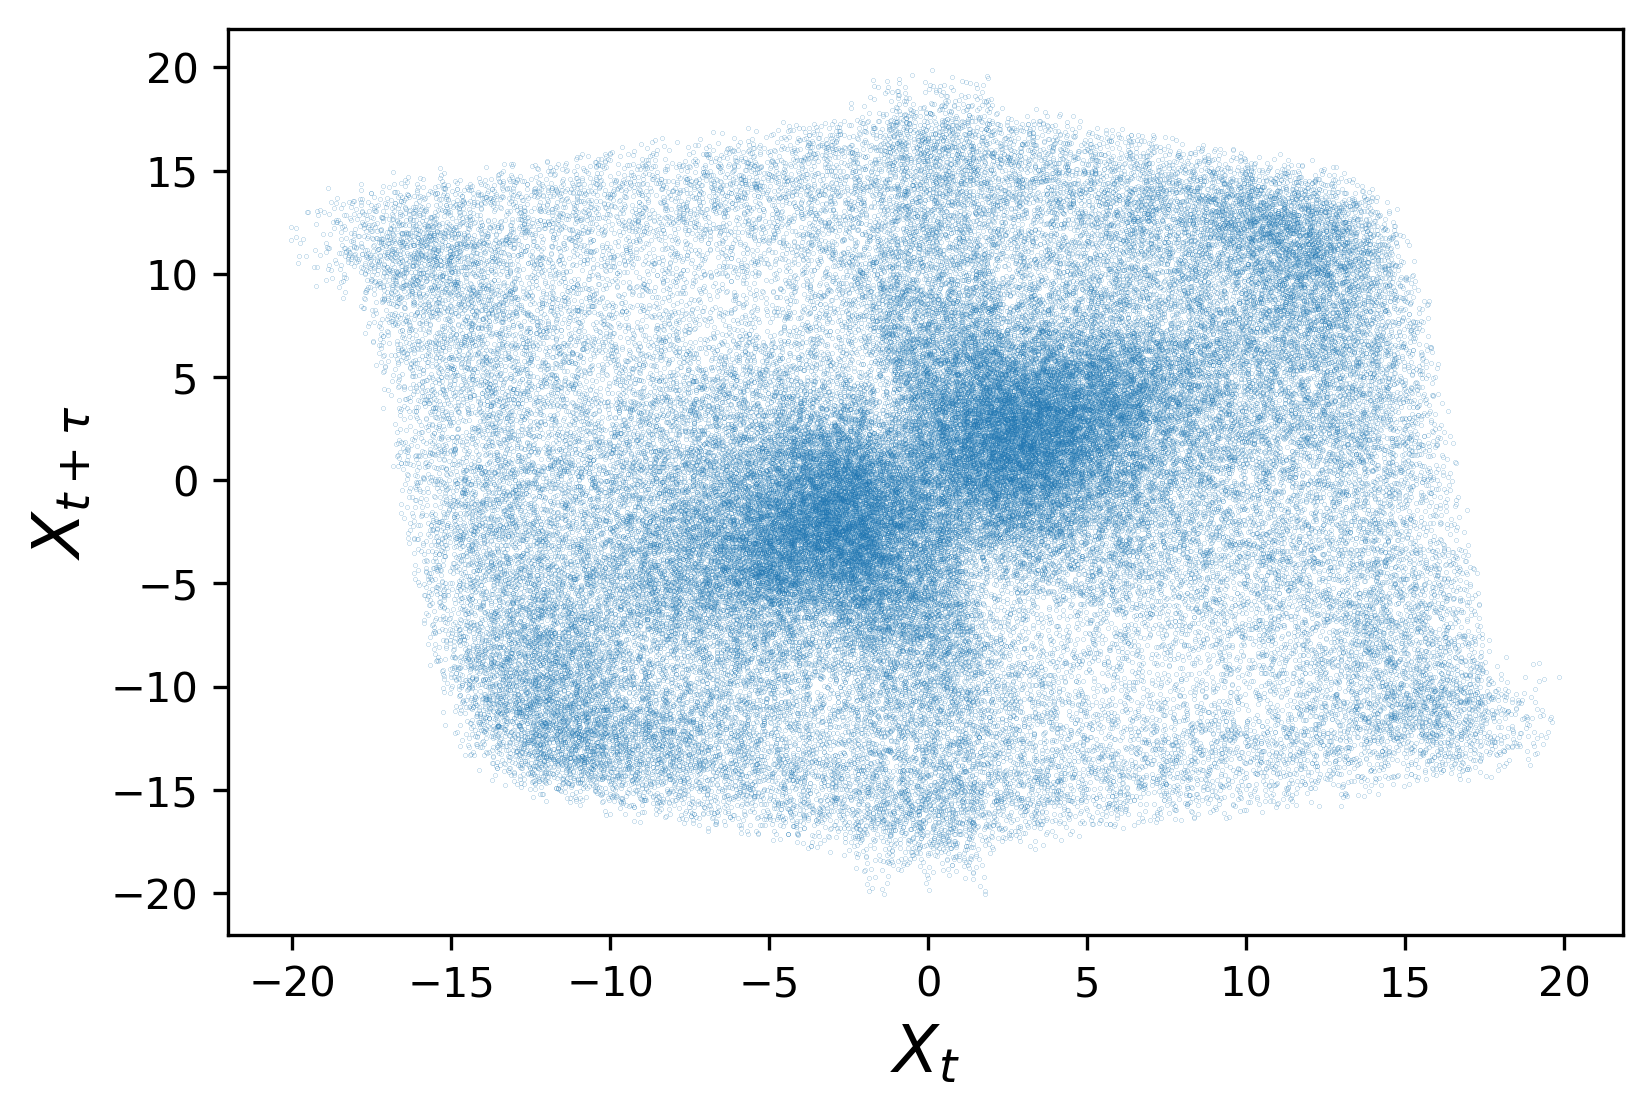

In [28]:
tau = 60
plt.figure(dpi=300)
plt.plot(lorenzTS[:-tau], lorenzTS[tau:], '.', markersize=.1)
plt.xlabel(r'$X_{t}$', fontsize=16)
plt.ylabel(r'$X_{t+\tau}$', fontsize=16)
plt.savefig('d2_figures_paper/lorenz_reconstruction_tau_{}_noise_{}.png'.format(tau, noise_level))


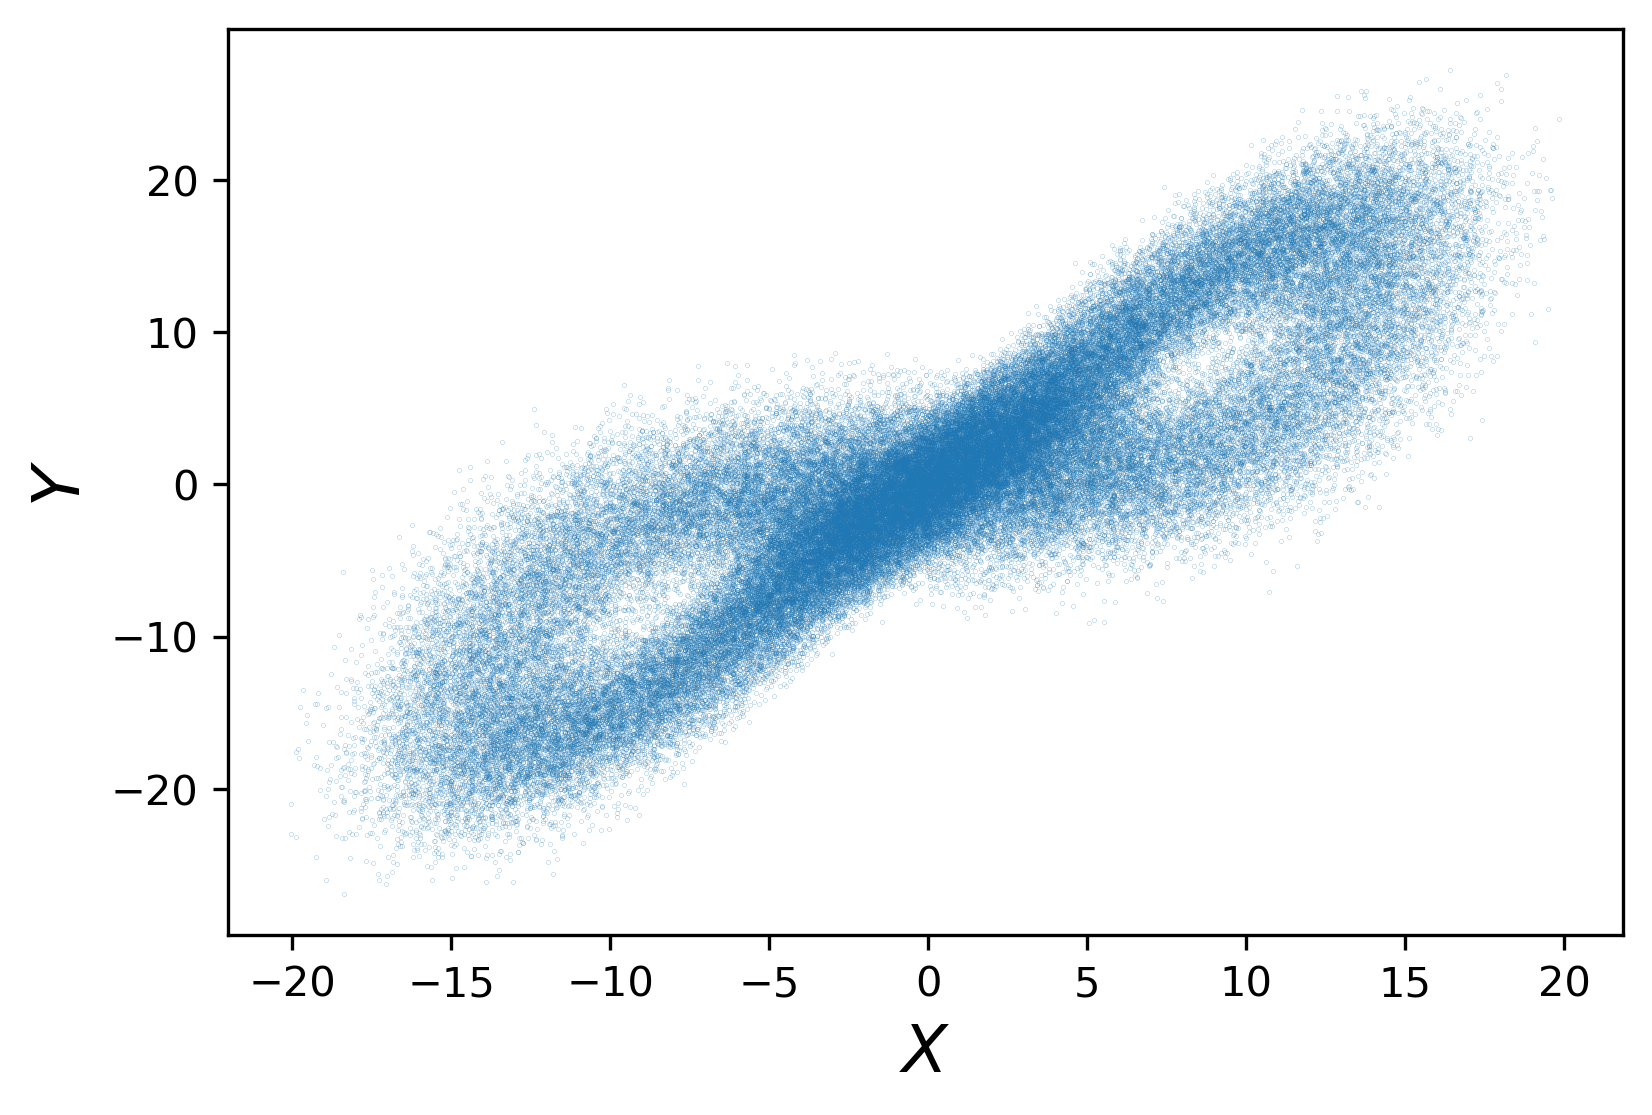

In [29]:
plt.figure(dpi=300)
plt.plot(data[:,0], data[:,1], '.', markersize=.1)
plt.xlabel(r'$X$', fontsize=16)
plt.ylabel(r'$Y$', fontsize=16)
plt.savefig('d2_figures_paper/lorenz_full_noise_{}.png'.format(noise_level))
